In [3]:
#| default_exp activations

In [4]:
# Install nbdev
# !pip uninstall nbdev
!pip install nbdev

from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.9 MB/s eta 0:00:00
Mounted at /content/drive


In [5]:
# Install the required modules to run this notebook

# Uninstall current version of torch and related packages and install teh correct version to build mini.ai module in the next step
#!pip uninstall -y torch torchvision torchaudio torchtext fastai torchdata
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 torchtext==0.14.1 fastai==2.7.11
!pip install torchdata==0.5.1
!pip install nbdev

# Hugging Face modules and some additional libraries this notebook requires
!pip install datasets
!pip install torcheval


# Install the miniai module
#!pip install -Uqq git+https://github.com/fastai/course22p2
!pip install -Uqq git+https://github.com/georgevetticaden/course22p2

# To view references to images/... in this notebook have to cd into the directory where this notebooks is.
#%cd drive/MyDrive/Git
%cd /content/drive/MyDrive/Git/course22p2/nbs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 81.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.8/232.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu121
    Unin

# Activation stats

In [6]:
#|export
from __future__ import annotations
import random,math,torch,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from functools import partial

from miniai.datasets import *
from miniai.learner import *

In [7]:
import torch.nn.functional as F,matplotlib as mpl
from pathlib import Path
from operator import attrgetter,itemgetter
from contextlib import contextmanager

from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from datasets import load_dataset

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['figure.constrained_layout.use'] = True

import logging
logging.disable(logging.WARNING)

In [8]:
#|export
def set_seed(seed, deterministic=False):
    torch.use_deterministic_algorithms(deterministic)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [9]:
set_seed(2)
torch_rand = torch.rand(3)
# Generate random numbers with Python's `random`
python_rand = [random.random() for _ in range(3)]
# Generate random numbers with NumPy
numpy_rand = np.random.rand(3)

print("PyTorch random numbers:", torch_rand)
print("Python random numbers:", python_rand)
print("NumPy random numbers:", numpy_rand)




PyTorch random numbers: tensor([0.61, 0.38, 0.64])
Python random numbers: [0.9560342718892494, 0.9478274870593494, 0.05655136772680869]
NumPy random numbers: [0.4359949  0.02592623 0.54966248]


In [10]:
x,y = 'image','label'
name = "fashion_mnist"

# Use HF to load fashion minist data into DataSetDict containing train and test
dsd = load_dataset(name)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

# Create a Dataset with tranform and should return
tds = dsd.with_transform(transformi)

# Creates DataLoaders with our collate function to return batch tuple of two tensors for image and label
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train

first_batch = next(iter(dt))
first_batch[0].shape # torch.Size([1024, 1, 28, 28]), 3-D for the image since we are working with convolutions


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([1024, 1, 28, 28])

## Baseline

In [11]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

def cnn_layers():
    return [
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        nn.Flatten()]

We want to train quickly, so that means training at a high learning rate.

In [12]:
from torcheval.metrics import MulticlassAccuracy

In [13]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]

In [14]:
def fit(model, epochs=1, xtra_cbs=None):
    learn = Learner(model, dls, loss_func=F.cross_entropy, lr=0.6, cbs=cbs+fc.L(xtra_cbs))
    learn.fit(epochs)
    return learn

accuracy,loss,epoch,train
0.156,2.297,0,train
0.284,2.021,0,eval


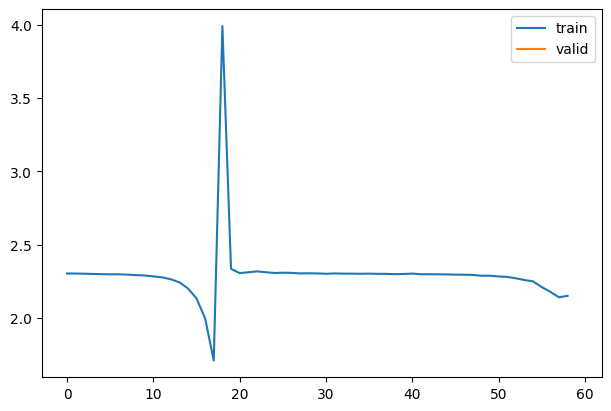

In [15]:
set_seed(1)
learn = fit(nn.Sequential(*cnn_layers()))

## Hooks

### Manual insertion

In [16]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]

    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(to_cpu(x).mean())
            self.act_stds [i].append(to_cpu(x).std ())
        return x

    def __iter__(self): return iter(self.layers)

In [17]:
model2 = cnn_layers();
model2

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Sequential(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ),
 Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
 Flatten(start_dim=1, end_dim=-1)]

accuracy,loss,epoch,train
0.154,2.302,0,train
0.203,2.126,0,eval


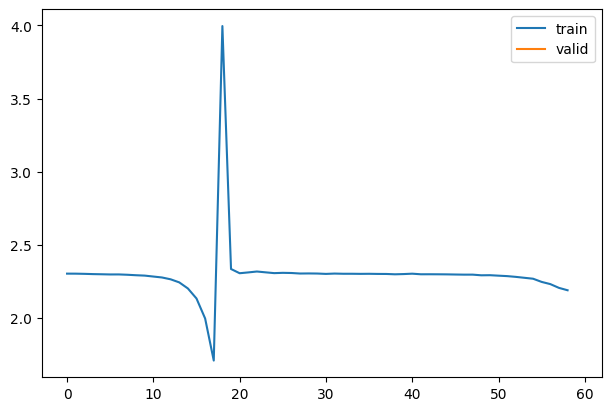

In [18]:
set_seed(1)
model = SequentialModel(*cnn_layers())
learn = fit(model)

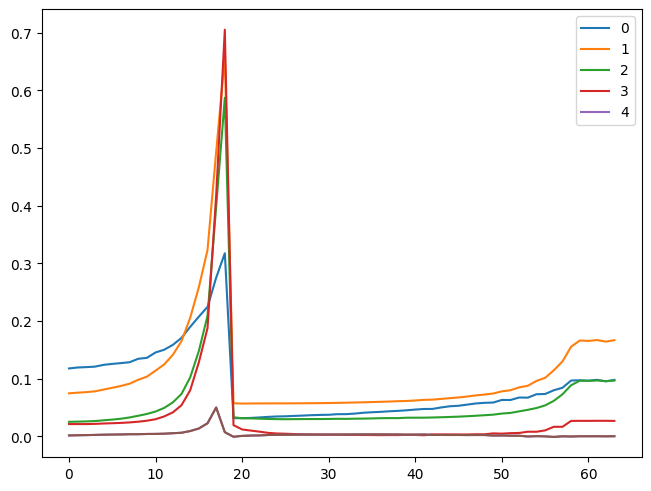

In [19]:
for l in model.act_means: plt.plot(l)
plt.legend(range(5));

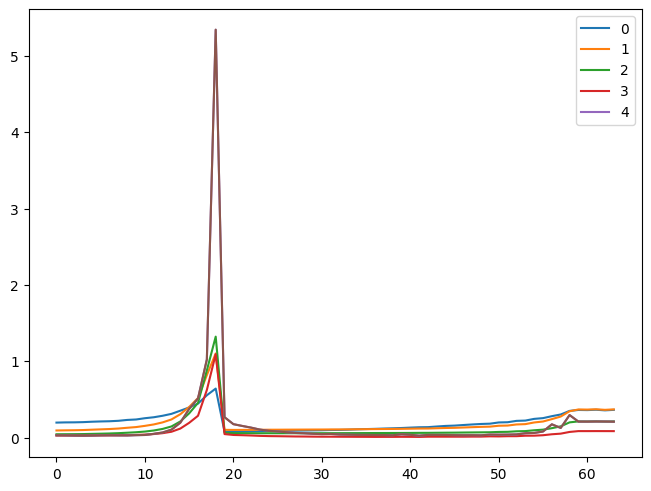

In [20]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(5));

### Pytorch hooks

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook). Hooks don't require us to rewrite the model.

In [21]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [22]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [23]:
act_means = [[] for _ in model] # [[], [], [], [], [], []] which represent 5 Conv2d layers and 1 flatten
act_stds  = [[] for _ in model]

In [24]:
act_means

[[], [], [], [], [], []]

In [25]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(to_cpu(outp).mean())
    act_stds [i].append(to_cpu(outp).std())

In [26]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

accuracy,loss,epoch,train
0.151,2.299,0,train
0.289,2.145,0,eval


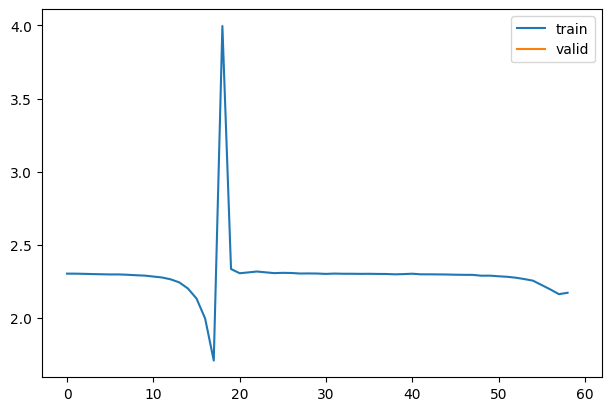

In [27]:
fit(model)

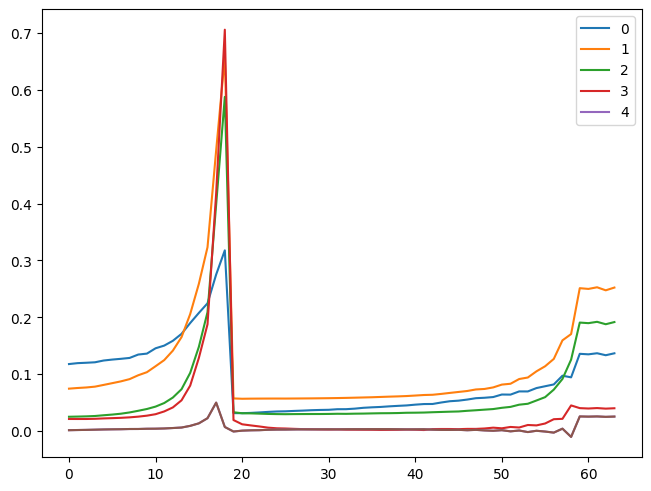

In [28]:
for o in act_means: plt.plot(o)
plt.legend(range(5));

### Hook class

We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [29]:
#| export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

In [30]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())

In [31]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

In [32]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [33]:
hooks = [Hook(l, append_stats) for l in model[:5].children()]

accuracy,loss,epoch,train
0.156,2.298,0,train
0.286,2.040,0,eval


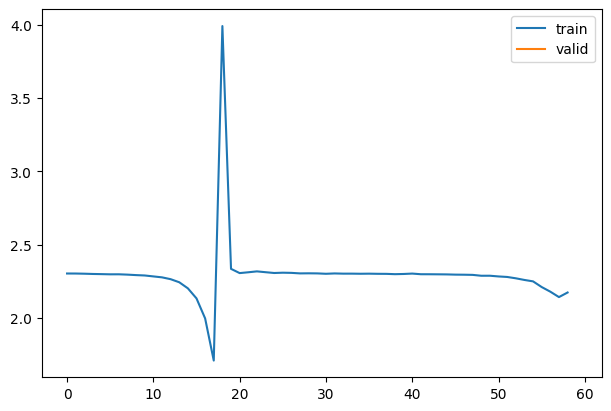

In [34]:
learn = fit(model)

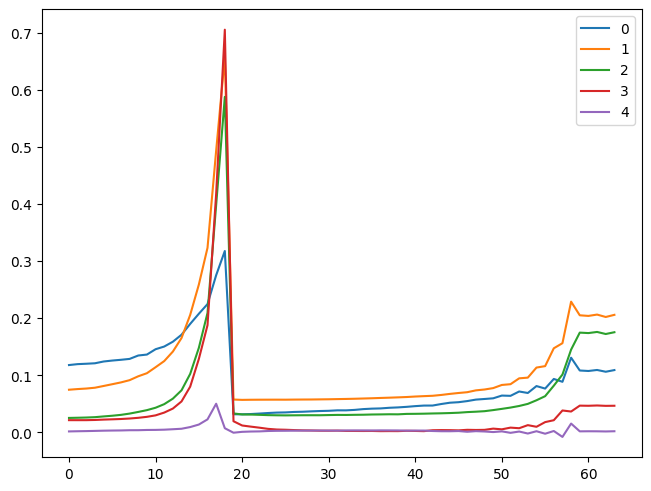

In [35]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(5));

### A Hooks class

In [36]:
class DummyCtxMgr:
    def __enter__(self, *args):
        print("let's go!")
        return self
    def __exit__ (self, *args): print("all done!")
    def hello(self): print("hello.")

In [37]:
with DummyCtxMgr() as dcm: dcm.hello()

let's go!
hello.
all done!


In [38]:
class DummyList(list):
    def __delitem__(self, i):
        print(f"Say bye to item {i}")
        super().__delitem__(i)

In [39]:
dml = DummyList([1,3,2])
dml

[1, 3, 2]

In [40]:
del(dml[2])
dml

Say bye to item 2


[1, 3]

In [41]:
#| export
class Hooks(list):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()

In [42]:
set_seed(1)
model = nn.Sequential(*cnn_layers())

accuracy,loss,epoch,train
0.156,2.297,0,train
0.290,2.013,0,eval


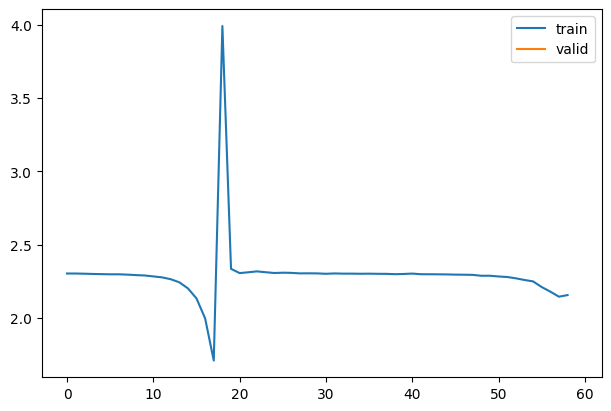

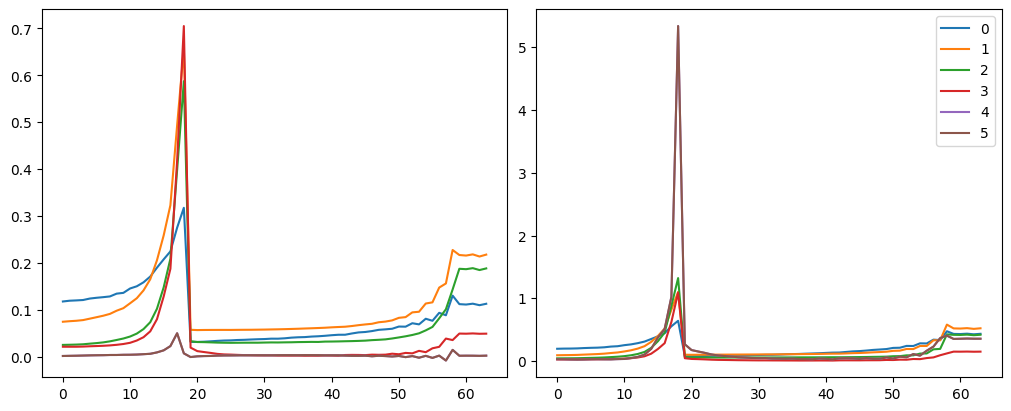

In [43]:
with Hooks(model, append_stats) as hooks:
    fit(model)
    fig,axs = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        for i in 0,1: axs[i].plot(h.stats[i])
    plt.legend(range(6));

### HooksCallback

In [44]:
#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

In [45]:
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.156,2.298,0,train
0.294,2.049,0,eval


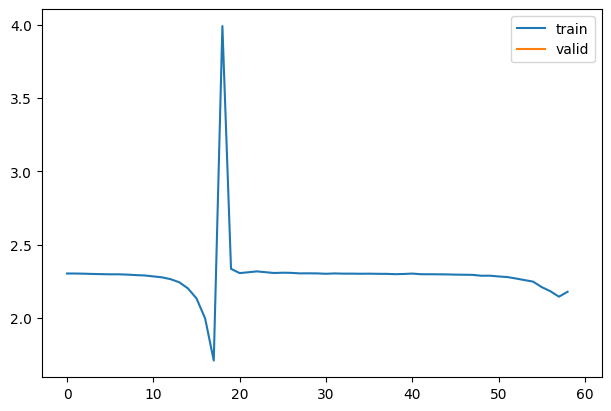

In [46]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[hc]);

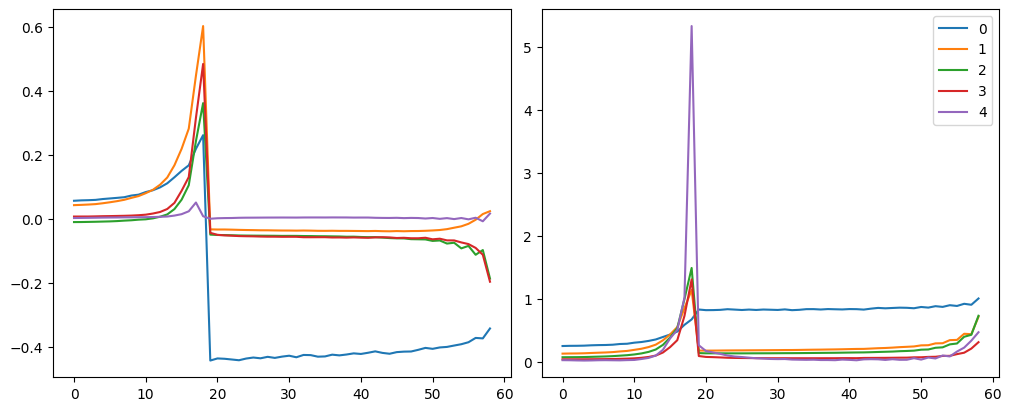

In [47]:
fig,axs = plt.subplots(1,2, figsize=(10,4))
for h in hc:
    for i in 0,1: axs[i].plot(h.stats[i])
plt.legend(range(6));

## Histograms

In [48]:
#| export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))

accuracy,loss,epoch,train
0.151,2.299,0,train
0.282,2.150,0,eval


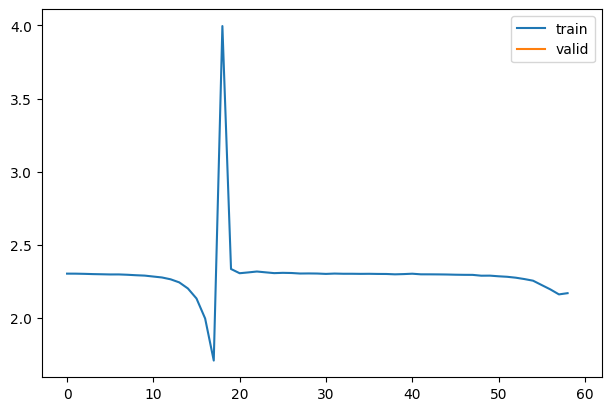

In [49]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
hc = HooksCallback(append_stats, mod_filter=fc.risinstance(nn.Conv2d))
fit(model, xtra_cbs=[hc]);

In [79]:
# iterating through HooksCallback returns iterator on Hooks which is a list of Hook
hook_of_first_layer = next(iter(hc))
assert isinstance(hook_of_first_layer, Hook)

# List of 1-D tensors that represents the histogram for every batch
histogram_stats = hook_of_first_layer.stats[2]

len(histogram_stats) # List has lenght 59 represengint the number of batches
histogram_stats[0].shape # torch.Size([40]) = Value in the list is a tensor which is 1-D tensor of lenght 40 which is the number of bins

# 1212566
histCountForFirstBin = histogram_stats[0][0]
# the first bin for activation values from 0 to .25 should have the most count
max_index = torch.argmax(histogram_stats[0])
assert max_index == tensor(0)

In [89]:
# iterating through HooksCallback returns iterator on Hooks which is a list of Hook
hook_of_first_layer = next(iter(hc))
assert isinstance(hook_of_first_layer, Hook)

# List of 1-D tensors that represents the histogram for every batch
histogram_stats = hook_of_first_layer.stats[2]

len(histogram_stats) # List has lenght 59 represengint the number of batches
histogram_stats[0].shape # torch.Size([40]) = Value in the list is a tensor which is 1-D tensor of lenght 40 which is the number of bins

# Stacking the list of 40  1-D tensors of lenght 40  will result in a single tensor of of shape [59, 40]
single_column_histogram = torch.stack(histogram_stats)
assert single_column_histogram.shape == torch.Size([59, 40])

#Transpose the tensor
transposed_single_column_histogram = single_column_histogram.t()
assert transposed_single_column_histogram.shape == torch.Size([40, 59])

# Make values smaller and allow us to the full rnage of activations more clearly
transposed_single_column_histogram[0].float().log1p()


tensor([14.01, 14.00, 14.00, 14.00, 14.00, 14.00, 14.00, 14.00, 13.99, 13.99, 13.97, 13.97, 13.96, 13.94, 13.92, 13.92, 13.91, 13.89, 13.86,
        13.65, 13.66, 13.66, 13.65, 13.64, 13.65, 13.65, 13.64, 13.64, 13.63, 13.64, 13.64, 13.63, 13.64, 13.64, 13.62, 13.62, 13.63, 13.62,
        13.62, 13.62, 13.62, 13.62, 13.63, 13.61, 13.60, 13.61, 13.61, 13.60, 13.61, 13.61, 13.60, 13.61, 13.60, 13.61, 13.60, 13.62, 13.61,
        13.62, 13.09])

In [50]:
#| export
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

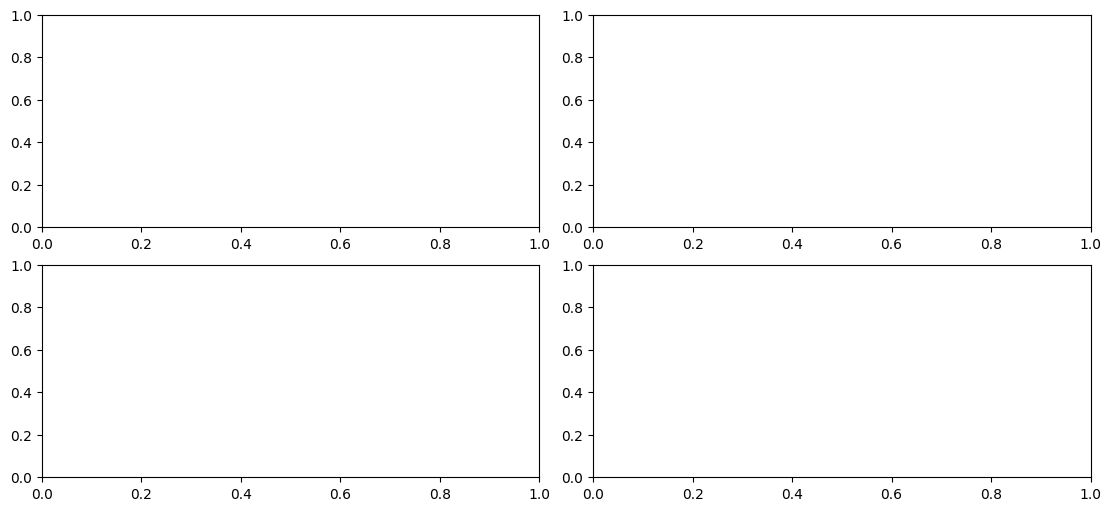

In [94]:
fig,axes = get_grid(len(hc), figsize=(11,5))
axes

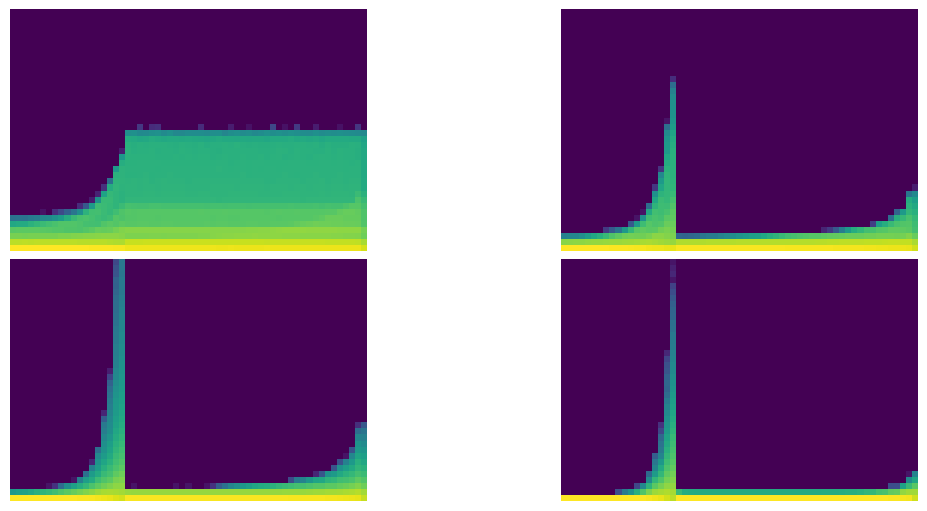

In [51]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flat, hc):
    show_image(get_hist(h), ax, origin='lower')

In [52]:
#| export
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[0]/h1.sum(0)

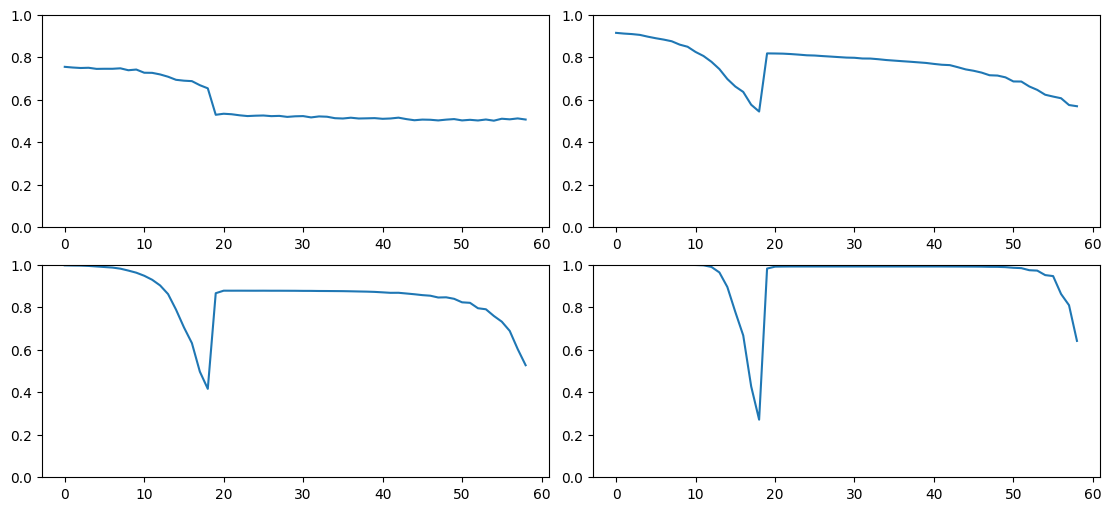

In [53]:
fig,axes = get_grid(len(hc), figsize=(11,5))
for ax,h in zip(axes.flatten(), hc):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)

## ActivationStats

In [54]:
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

In [55]:
astats = ActivationStats(fc.risinstance(nn.Conv2d))

accuracy,loss,epoch,train
0.151,2.298,0,train
0.100,2.214,0,eval


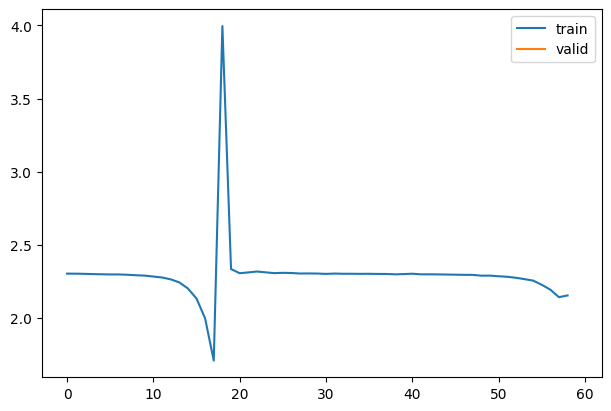

In [56]:
set_seed(1)
model = nn.Sequential(*cnn_layers())
fit(model, xtra_cbs=[astats]);

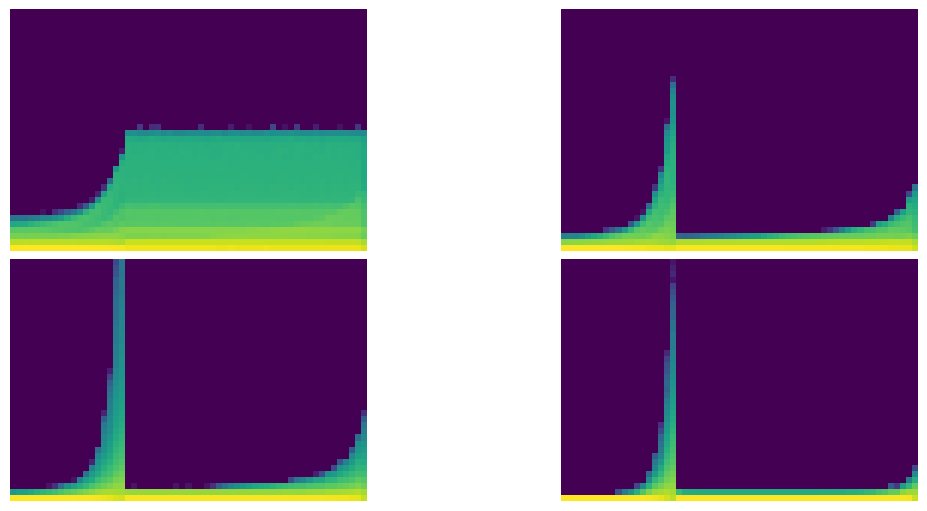

In [57]:
astats.color_dim()

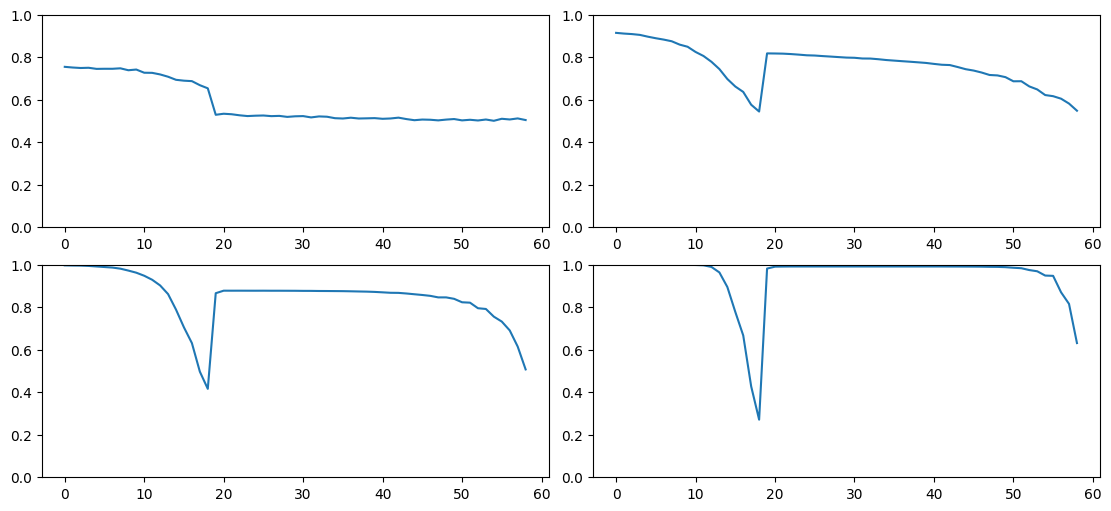

In [58]:
astats.dead_chart()

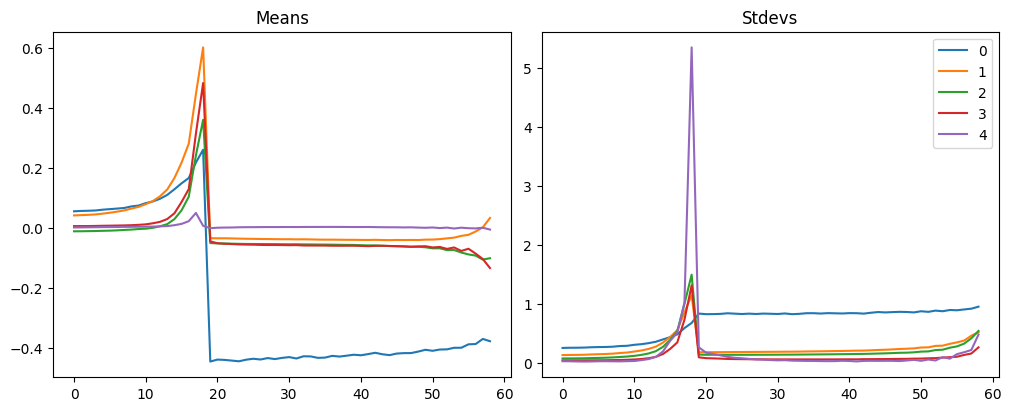

In [59]:
astats.plot_stats()

## Export -

In [60]:
import nbdev; nbdev.nbdev_export()